In [76]:
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import bs4 as bs
import requests
import yfinance as yf
import numpy

# Useful to retrieve the company name afterwards
def get_SP500_df():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    html_content = requests.get(url).text
    soup = bs.BeautifulSoup(html_content, 'lxml')
    table = soup.find("table", attrs = { "id" : "constituents"})
    all_rows_table = []
    for tr in table.find_all('tr'):
        iterating_list = []
        for td in tr.find_all('td'):
            content = td.text
            content = content.replace("\n", "")
            iterating_list.append(content)
        all_rows_table.append(iterating_list)

    df = pd.DataFrame(all_rows_table, columns = ['Symbol', 'Security', 'SEC_filings', 'GICS_Sector', 'GICS_Sub_Industry', 'Headquarters_Location', 'Date_first_added', 'CIK', 'Founded'])
    df = df[1:]
    del df['SEC_filings']
    df.iloc[71,0] = 'BRK-B'
    df.loc[df['Symbol']=='BF.B', 'Symbol'] = 'BF-B'
    return df

# Useful to retrieve the tickers (unsorted), that correspond to the SP500df
def get_SP500_tickers():
    df = get_SP500_df()
    tickers = df["Symbol"].tolist()
    tickers_exceptions = ['CTVA', 'DOW', 'FOXA', 'FOX', 'LHX']
    for element in tickers_exceptions:
        tickers.remove(element)
    return tickers

# Useful to get the complete time series to run the model
def get_time_series_df():
    from datetime import date
    today = date.today()
    end_date = today.strftime("%Y-%m-%d")
    tickers = get_SP500_tickers()
    ticker_data = yf.download(tickers, '2010-01-01', end_date, interval='1d')
    adj_closing_prices = ticker_data.iloc[:, 0:500]
    to_split_df = adj_closing_prices.copy()
    column_list = []
    for column in to_split_df.columns:
        ticker_name = column[1]
        column_list.append(ticker_name)
    to_split_df.columns = column_list
    return to_split_df

def update_csv_SP500():
    adj_closing_prices = get_time_series_df()
    adj_closing_prices.to_csv('SP500_closing_prices.csv')

print(get_time_series_df())
update_csv_SP500()


[*********************100%***********************]  500 of 500 downloaded
                A    AAL     AAP    AAPL   ABBV    ABC    ABMD    ABT     ACN  \
Date                                                                            
2009-12-31  20.65   4.59   39.53   26.27    NaN  22.54    8.73  20.38   33.69   
2010-01-04  20.80   4.53   39.43   26.68    NaN  23.02    8.74  20.56   34.15   
2010-01-05  20.57   5.04   39.20   26.73    NaN  22.86    8.53  20.39   34.36   
2010-01-06  20.50   4.83   39.54   26.30    NaN  22.64    8.40  20.50   34.72   
2010-01-07  20.47   4.97   39.53   26.25    NaN  22.28    8.40  20.67   34.69   
2010-01-08  20.47   4.88   39.69   26.43    NaN  22.52    8.23  20.78   34.55   
2010-01-11  20.48   4.78   39.30   26.20    NaN  22.77    8.08  20.88   34.52   
2010-01-12  20.24   4.82   38.61   25.90    NaN  22.93    7.89  20.82   34.30   
2010-01-13  20.40   5.20   39.15   26.26    NaN  23.38    7.96  21.02   34.69   
2010-01-14  20.70   5.31   38.63   

[*********************100%***********************]  500 of 500 downloaded


1628 803
Epoch 1/2
 - 28s - loss: 0.0505
Epoch 2/2
 - 1s - loss: 0.0204
Train Score: 7.11 RMSE
Test Score: 31.46 RMSE


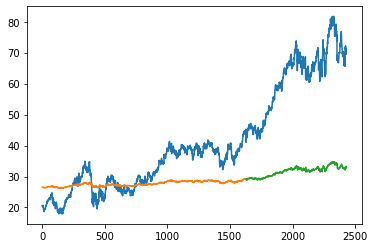

1628 803
Epoch 1/2
 - 25s - loss: 0.1912
Epoch 2/2
 - 0s - loss: 0.1096
Train Score: 15.10 RMSE
Test Score: 25.19 RMSE


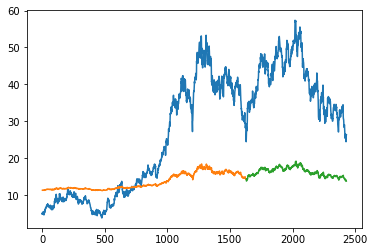

1628 803
Epoch 1/2
 - 25s - loss: 0.2103
Epoch 2/2
 - 0s - loss: 0.1180
Train Score: 46.43 RMSE
Test Score: 69.48 RMSE


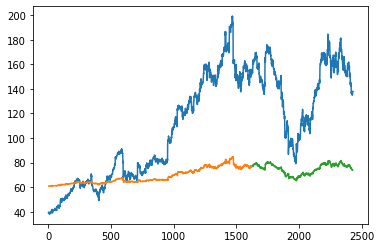

                        0                        1                   2    \
0                         A                      AAL                 AAP   
1  Agilent Technologies Inc  American Airlines Group  Advance Auto Parts   
2                     71.11                    26.31              137.95   
3                   32.7965                  13.7662             73.8343   
4                 -0.538791                 -0.47677           -0.464775   
5                   31.4622                   25.186             69.4773   

          3            4                       5            6    \
0        AAPL         ABBV                     ABC         ABMD   
1  Apple Inc.  AbbVie Inc.  AmerisourceBergen Corp  ABIOMED Inc   
2        None         None                    None         None   
3        None         None                    None         None   
4        None         None                    None         None   
5        None         None                    None         None  

In [78]:
# LSTM Model:
def LSTM():
    list_of_lists = []
    list_RMSE = []
    list_return = []
    list_latest_price = []
    list_predict_price = []
    
    my_dict = {}
    df = get_SP500_df()
    for x in range(len(df)):
            ticker = df.iloc[x][0]
            company = df.iloc[x][1]
            my_dict[ticker] = company 
    
    # Model is meant to gather all of the SP500 data. For code-verification-purposes reduce the range from 501 to 2
    # to get a result only for the first company (alphabetical order)
    
    for item in range(1,501):
        import numpy
        import matplotlib.pyplot as plt
        import pandas
        import math
        from keras.models import Sequential
        from keras.layers import Dense
        from keras.layers import LSTM
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.metrics import mean_squared_error
        import tensorflow as tf

        # fix random seed for reproducibility
        numpy.random.seed(7)

        # load dataset and change values to float
        dataframe = pandas.read_csv('SP500_closing_prices.csv', usecols=[item], skiprows = [0,2], engine='python')
        dataset = dataframe.values

        dataframe = dataframe.dropna(how = 'any')
        dataset = dataframe.values

        #print(dataframe['A'].isna().all().sum())
        dataset = dataset.astype('float64')
        latest_price = float(dataset[-1][0])
        list_latest_price.append(latest_price)

        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        

        # split into train and test sets
        train_size = int(len(dataset) * 0.67)
        test_size = len(dataset) - train_size
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
        print(len(train), len(test))

        # convert an array of values into a dataset matrix
        def create_dataset(dataset, look_back=1):
            dataX, dataY = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
            return numpy.array(dataX), numpy.array(dataY)

        # reshape into X=t and Y=t+1
        look_back = 3
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(10, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=100, batch_size=40, verbose=2)

        # For speeding the process epochs might be changed to lower number, it also reduces the precision, so 
        # it's only meant for testing pursoses that way.
        
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        latest_prediction = float(testPredict[-1][0])
        list_predict_price.append(latest_prediction)
        model_return = (latest_prediction - latest_price) / latest_price
        list_return.append(model_return)
        
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))

        # shift train predictions for plotting
        trainPredictPlot = numpy.empty_like(dataset)
        trainPredictPlot[:, :] = numpy.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

        # shift test predictions for plotting
        testPredictPlot = numpy.empty_like(dataset)
        testPredictPlot[:, :] = numpy.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

        # plot baseline and predictions
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()
        list_RMSE.append(testScore)
    dataframe1 = pandas.read_csv('SP500_closing_prices.csv')
    dataset1 = pandas.DataFrame(dataframe1)
    listoft = list(dataset1.columns.values[1:])
    list_of_lists.append(listoft)
    listofnames = []
    for ticker in listoft:
        listofnames.append(my_dict[ticker])
    
    list_of_lists.append(listofnames)
    
    list_of_lists.append(list_latest_price)
    list_of_lists.append(list_predict_price)
    list_of_lists.append(list_return)
    list_of_lists.append(list_RMSE)
    exporting_df = pandas.DataFrame(list_of_lists)
    
    exporting_df.to_csv('model_result.csv')
    
    df_front_copy = exporting_df.T.copy()
    df_front_copy = df_front_copy.iloc[:,[0,1,4,5]]
    df_front_copy.sort_values(4, inplace = True, ascending = False)
    df_front_copy = df_front_copy.head(10)
    df_front_copy.columns = ["Ticker","Company","Expected Return","Reliability (RMSE)"]
    
    df_front_copy.to_csv('from_backend_with_love.csv')
    return exporting_df
    
print(LSTM())


